In [1]:
import numpy as np
import matplotlib
import math
import matplotlib.pyplot as plt
# you need to install BigFile
from bigfile import BigFile
import glob,os,struct
# from astropy.cosmology import FlatLambdaCDM
# import astropy.units as u
from scipy.interpolate import interp1d
from colossus.cosmology import cosmology

import seaborn as sns

sns.set()
sns.set_palette("Set2")
sns.set_style('ticks',{'ytick.direction':'in','xtick.direction':'in'})

cmap = plt.get_cmap("Set2")
sns.set_context("paper", font_scale=1.7,rc={"axes.linewidth": 1.3,"lines.linewidth": 2.5,"patch.linewidth": 2.2})
from matplotlib import rcParams as rc
import pickle
import warnings

import import_ipynb
import Low_Redshift_Tuple_IDs as tuples

importing Jupyter notebook from Low Redshift Tuple IDs.ipynb
Number of triples: 553
Number of quadruples: 64


In [2]:
triples = tuples.z1_triples
quadruples = tuples.z1_quadruples

BH Mass, Host Mass, Luminosity, Distance from Center of Host

In [3]:
c_mks = 3e8
msun_mks = 2e30
s_to_year = 3.17098e-8
year_to_s = 1./s_to_year
lsun_ergs = 3.9e33
mdot_msun_yr = 1e10/980/1e6

In [4]:
def calc_lx(mdot):
    """
    input: mdot in Msun/yr
    output: Lx in ergs
    """
    lbol = 0.1*mdot*msun_mks/year_to_s*c_mks**2
    lbol_lsun = lbol/3.9e26
    k = 10.83*(lbol_lsun/1e10)**0.28 \
        + 6.08*(lbol_lsun/1e10)**(-0.02)
    return lbol/k*1e7

In [5]:
pig = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_483')
battr = pig["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
Lbox = battr['BoxSize']
hh = battr['HubbleParam']
om0 = battr['Omega0']
omb = battr['OmegaBaryon']
oml = battr['OmegaLambda']
Nfof = battr['NumFOFGroupsTotal']
sigma8 = 0.82
print('----------PIG file info------------')

print('Redshift = %.2f'%redshift)
print('Lbox = %d ckpc/h'%Lbox)
print('NfofGroups = %d'%Nfof)

print('------cosmological parameters-----')
print('h = %.4f'%hh)
print('Omega_m = %.4f'%om0)
print('Omega_b = %.4f'%omb)
print('Omega_l = %.4f'%oml)

----------PIG file info------------
Redshift = 1.30
Lbox = 250000 ckpc/h
NfofGroups = 177398278
------cosmological parameters-----
h = 0.6774
Omega_m = 0.3089
Omega_b = 0.0486
Omega_l = 0.6911


In [6]:
BHIDs = pig.open('5/ID')[:]
BHPos = pig.open('5/Position')
BHMass = pig.open('5/BlackholeMass')
BHAccr = pig.open('5/BlackholeAccretionRate')
MassByType = pig.open('FOFGroups/MassByType')[:5000000]*1e10/hh

In [7]:
vals = []

for trip in triples:
    for bhid in trip:
        idx = (BHIDs==bhid).nonzero()[0][0]
        
        mass = BHMass[idx]
        accr = BHAccr[idx]
        
        vals.append((bhid, mass, accr))

In [8]:
def get_distance(p1, p2):
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    
    return (math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)/(1 + redshift)/hh)

In [9]:
vals = []

for trip in triples:
    id1, id2, id3 = trip
    
    idx1 = (BHIDs==id1).nonzero()[0][0]
    idx2 = (BHIDs==id2).nonzero()[0][0]
    idx3 = (BHIDs==id3).nonzero()[0][0]
    
    m1, m2, m3 = BHMass[idx1], BHMass[idx2], BHMass[idx3]
    a1, a2, a3 = BHAccr[idx1], BHAccr[idx2], BHAccr[idx3]
    
    p1, p2, p3 = BHPos[idx1], BHPos[idx2], BHPos[idx3]
    
    dr1 = get_distance(p1, p2)
    dr2 = get_distance(p1, p3)
    dr3 = get_distance(p2, p3)
    
    drs = sorted([dr1, dr2, dr3])
    
    drmin, drmed, drmax = drs[0], drs[1], drs[2]
    
    maxacr = max(a1, a2, a3)
    
    vals.append((id1, id2, id3, m1, m2, m3, a1, a2, a3, maxacr, drmin, drmed, drmax))

In [10]:
triples_values = np.array(vals, dtype=[('ID1', '<f8'), ('ID2', '<f8'), ('ID3', '<f8'), ('BHMass1', '<f8'),
                                       ('BHMass2', '<f8'), ('BHMass3', '<f8'), ('Accr1', '<f8'), ('Accr2', '<f8'),
                                       ('Accr3', '<f8'), ('MaxAcrr', '<f8'), ('drmin', '<f8'), ('drmed', '<f8'), ('drmax', '<f8')])

## Sanity Checks

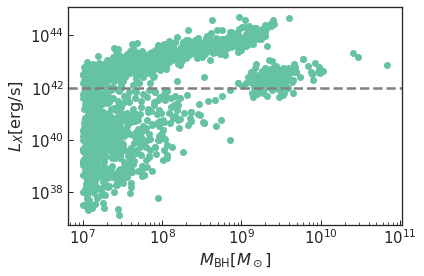

In [11]:
plt.scatter(triples_values['BHMass1']*1e10/hh, calc_lx(triples_values['Accr1']*mdot_msun_yr),color=cmap(0))
plt.scatter(triples_values['BHMass2']*1e10/hh, calc_lx(triples_values['Accr2']*mdot_msun_yr),color=cmap(0))
plt.scatter(triples_values['BHMass3']*1e10/hh, calc_lx(triples_values['Accr3']*mdot_msun_yr),color=cmap(0))
plt.axhline(10**42, color='grey', linestyle='--',label=r'$10^{42}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M_{\rm BH} [M_\odot]$')
plt.ylabel(r'$L_X [\rm erg/s]$')
plt.show()

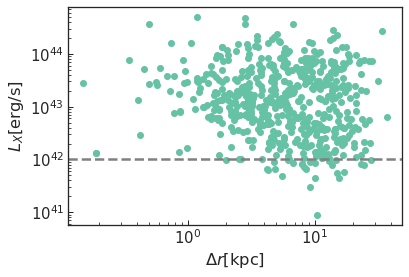

In [12]:
plt.scatter(triples_values['drmin'], calc_lx(triples_values['MaxAcrr']*mdot_msun_yr),color=cmap(0))
plt.axhline(10**42, color='grey', linestyle='--',label=r'$10^{42}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\Delta r [\rm kpc]$')
plt.ylabel(r'$L_X [\rm erg/s]$')
plt.show()

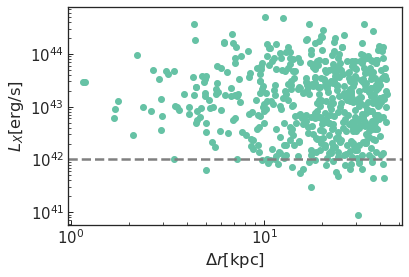

In [13]:
plt.scatter(triples_values['drmed'], calc_lx(triples_values['MaxAcrr']*mdot_msun_yr),color=cmap(0))
plt.axhline(10**42, color='grey', linestyle='--',label=r'$10^{42}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\Delta r [\rm kpc]$')
plt.ylabel(r'$L_X [\rm erg/s]$')
plt.show()

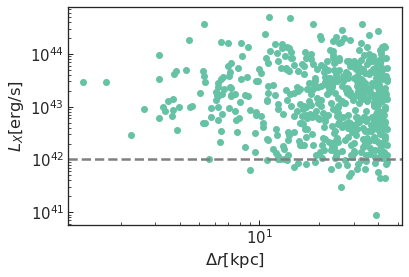

In [14]:
plt.scatter(triples_values['drmax'], calc_lx(triples_values['MaxAcrr']*mdot_msun_yr),color=cmap(0))
plt.axhline(10**42, color='grey', linestyle='--',label=r'$10^{42}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\Delta r [\rm kpc]$')
plt.ylabel(r'$L_X [\rm erg/s]$')
plt.show()

In [15]:
def mass_func(m,Lbox,lim_min,lim_max,nbin,hh):
    bins = np.logspace(lim_min,lim_max,nbin)
    center = np.log10(bins)[:-1]+np.diff(np.log10(bins))/2
    count = np.histogram(m,bins)

    mask = count[0]>0
    fac = np.diff(np.log10(bins))*(Lbox/hh)**3
    yy = count[0]/fac
    err = yy[mask]/np.sqrt(count[0][mask])
    y1 = yy[mask]+err
    y2 = yy[mask]-err
    y2[y2<=0] = 1e-50
    return np.power(10,center[mask]),yy[mask], y1, y2

In [16]:
FOF_masses = []

encountered = {}

for tup in triples:
    for id1 in tup[0:1]:
        idx1 = (BHIDs==id1).nonzero()[0][0]

        group1 = pig.open('5/GroupID')[idx1]
        gidx=group1-1

        if gidx in encountered:
            encountered[gidx] += 1
            break
        else:
            encountered[gidx] = 1

        FOFMass = pig.open('FOFGroups/MassByType')[gidx][1]*1e10/hh

        FOF_masses.append(FOFMass)

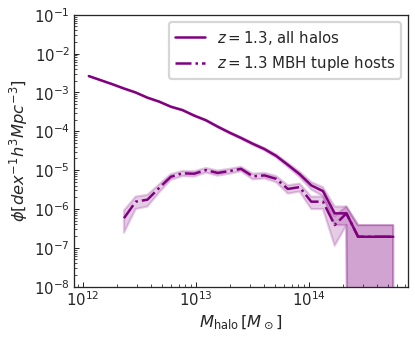

In [17]:
x1,y1,y_lower1,y_upper1 = mass_func(MassByType[:,1],Lbox=250,lim_min=12,lim_max=15,nbin=30,hh=hh)
x2,y2,y_lower2,y_upper2 = mass_func(FOF_masses,Lbox=250,lim_min=12,lim_max=15,nbin=30,hh=hh)

fig,ax = plt.subplots(figsize=(6,5),ncols=1,nrows=1)

ax.plot(x1,y1,c='purple',label=r'$z=1.3$, all halos')
ax.fill_between(x1,y_lower1,y_upper1,color='purple',alpha=0.2)
ax.plot(x2,y2,c='purple',label=r'$z=1.3$ MBH tuple hosts',linestyle='dashdot')
ax.fill_between(x2,y_lower2,y_upper2,color='purple',alpha=0.2)

ax.set(xscale='log',yscale='log',ylim=[1e-8,0.1],\
       xlabel=r'$M_{\rm halo}\,[M_\odot]$',ylabel=r'$\phi [dex^{-1} h^3 Mpc^{-3}]$')
ax.legend(loc='best')

plt.show()

In [18]:
path = '/hildafs/datasets/Asterix/BH_details_dict/Read-Blackhole-Detail'
detail = BigFile(path)
AllIDs = detail.open('BHID')[:]
Index = detail.open('Index')[:]

In [19]:
params = {'flat': True, 'H0': 100*hh, 'Om0': om0, 'Ob0': omb, 'sigma8': sigma8, 'ns': 0.96}
cosmo = cosmology.setCosmology('myCosmo', params)

# conversion between time and redshift
z_arr = np.linspace(0,10,500)
time = cosmo.age(z_arr) # Gyr
def z_to_t(x):
    return interp1d(z_arr, time,fill_value='extrapolate')(x)
def t_to_z(x):
    return interp1d(time, z_arr,fill_value='extrapolate')(x) 

In [20]:
c_mks = 3e8
msun_mks = 2e30
s_to_year = 3.17098e-8
year_to_s = 1./s_to_year
lsun_ergs = 3.9e33
mdot_msun_yr = 1e10/980/1e6
def calc_lx(mdot):
    """
    input: mdot in Msun/yr
    output: Lx in ergs
    """
    lbol = 0.1*mdot*msun_mks/year_to_s*c_mks**2
    lbol_lsun = lbol/3.9e26
    k = 10.83*(lbol_lsun/1e10)**0.28 \
        + 6.08*(lbol_lsun/1e10)**(-0.02)
    return lbol/k*1e7

def calc_lbol(mdot):
    """
    input: mdot in Msun/yr
    output: Lx in ergs
    """
    lbol = 0.1*mdot*msun_mks/year_to_s*c_mks**2
    lbol_ergs = lbol*1e7
    return lbol_ergs
def density_to_msunpc3(a): # density in mass/len^3 unit
    mass_msun = 1e10/hh
    length_pc = a*1000/hh
    rho = mass_msun/(length_pc)**3
    return rho

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [21]:
def calc_vel(bh,z,fv='extrapolate',kind = 'linear'):
    fx = interp1d(bh['z'],bh['BHvel'][:,0],fill_value=fv,kind = kind)
    fy = interp1d(bh['z'],bh['BHvel'][:,1],fill_value=fv,kind = kind)
    fz = interp1d(bh['z'],bh['BHvel'][:,2],fill_value=fv,kind = kind)
    return np.array([fx(z),fy(z),fz(z)])

def calc_pos2(bh,z,fv='extrapolate',kind = 'linear'):
    fx = interp1d(bh['z'],bh['BHpos'][:,0],fill_value=fv,kind = kind)
    fy = interp1d(bh['z'],bh['BHpos'][:,1],fill_value=fv,kind = kind)
    fz = interp1d(bh['z'],bh['BHpos'][:,2],fill_value=fv,kind = kind)
    return np.array([fx(z),fy(z),fz(z)])

def edd_ratio(mass,lum):
    return lum/(1.26e38*mass)

In [22]:
def get_bh_history(bhid):
    idx = (AllIDs==bhid).nonzero()[0][0]
    chunk = Index[idx]
    # print('File number of the target BHs:',chunk)
    # now load bh data
    outdir = '/hildafs/datasets/Asterix/BH_details_dict/'
    save = outdir+'BlackholeDetails-%04d'%chunk
    with open(save, 'rb') as f:
        data = pickle.load(f)
        f.close()
    bh = data[bhid]
    return bh

In [23]:
def plot_trip_history(bh1,bh2,bh3,zmerge,save=None, rmin=0.1, rmax=200):
    
    m1 = min(bh1['BHMass'][bh1['z']<3.2])
    m2 = min(bh2['BHMass'][bh2['z']<3.2])
    m3 = min(bh3['BHMass'][bh3['z']<3.2])
    
    if m2 > max(m1,m3):
        bh1,bh2,bh3 = bh2,bh1,bh3
    elif m3 > max(m1,m2):
        bh1,bh2,bh3 = bh3,bh1,bh2
    
    # total mergers before z=2
    dm1 = bh1['BHMass'][1:] - bh1['BHMass'][:-1]
    mask1 = (bh1['z'][:-1] < 4) & (bh1['acBHMass'][:-1] > 1e-6)
    dm2 = bh2['BHMass'][1:] - bh2['BHMass'][:-1]
    mask2 = (bh2['z'][:-1] < 4)& (bh2['acBHMass'][:-1] > 1e-6)
    dm3 = bh3['BHMass'][1:] - bh3['BHMass'][:-1]
    mask3 = (bh3['z'][:-1] < 4)& (bh3['acBHMass'][:-1] > 1e-6)
    print(sum(mask1), sum(mask2), sum(mask3))
    
    t1 = z_to_t(bh1['z'])
    t2 = z_to_t(bh2['z'])
    t3 = z_to_t(bh3['z'])
    
    a1 = 1./(bh1['z']+1.)
    a2 = 1./(bh2['z']+1.)
    a3 = 1./(bh3['z']+1.)
    
    
    lbol1 = calc_lbol(bh1['Mdot']*mdot_msun_yr)
    lbol2 = calc_lbol(bh2['Mdot']*mdot_msun_yr)
    lbol3 = calc_lbol(bh3['Mdot']*mdot_msun_yr)
    

    
    
    zz = np.linspace(zmerge-1.4,zmerge+1.5,1000)
    tt = z_to_t(zz)
    
    v1 = calc_vel(bh1,zz)
    v2 = calc_vel(bh2,zz)
    v3 = calc_vel(bh3,zz)
    
    dv = np.linalg.norm(v1-v2,axis=0)
    
    dr1 = np.linalg.norm(calc_pos2(bh1,zz) - calc_pos2(bh2,zz),axis=0)/(zz+1)/hh
    dr2 = np.linalg.norm(calc_pos2(bh1,zz) - calc_pos2(bh3,zz),axis=0)/(zz+1)/hh
    dr3 = np.linalg.norm(calc_pos2(bh2,zz) - calc_pos2(bh3,zz),axis=0)/(zz+1)/hh
    
    fig,ax = plt.subplots(figsize=(8,6),ncols=1,nrows=3,sharex=True)
    plt.subplots_adjust(hspace=0.)
    plt.subplots_adjust(left=0.07, right=0.99, top=0.92, bottom=0.14)
    ax[0].plot(t1,lbol1,color=cmap(0),label='BH1:%d'%bh1['BHID'][0])
    ax[0].plot(t2,lbol2,color=cmap(1),label='BH2:%d'%bh2['BHID'][0])
    ax[0].plot(t3,lbol3,color=cmap(2),label='BH3:%d'%bh3['BHID'][0])
    
    # ax[1].plot(t1,bh1['Density']*density_to_msunpc3(a1),color=cmap(0))
    # ax[1].plot(t2,bh2['Density']*density_to_msunpc3(a2),color=cmap(1),label='BH2:%d'%bh2['BHID'][0])
    # ax[1].plot(t3,bh3['Density']*density_to_msunpc3(a3),color=cmap(2),label='BH3:%d'%bh3['BHID'][0])
    
    ax[1].plot(t1,bh1['BHMass']*1e10/hh,color=cmap(0))
    ax[1].plot(t2,bh2['BHMass']*1e10/hh,color=cmap(1))
    ax[1].plot(t3,bh3['BHMass']*1e10/hh,color=cmap(2))
    
    # ax[0].legend()
    
    mmin = 5e6
    mmax = max(np.concatenate([bh1['BHMass'],bh2['BHMass'],bh3['BHMass']]))*1e10/hh * 3
    
    # mask = zz>=zmerge
    mask = zz>-100
    ax[2].plot(tt[mask],dr1[mask],color=cmap(1))
    ax[2].plot(tt[mask],dr2[mask],color=cmap(2))
    # Included for referee report
    ax[2].plot(tt[mask],dr3[mask],color=cmap(3))
    
    ax[0].set(yscale='log',ylabel=r'$L_{\rm bol}[erg/s]$')
    # ax[1].set(yscale='log',ylabel=r'$\rho_{\rm gas}[M_\odot/pc^3]$')
    ax[1].set(yscale='log',ylabel=r'$M_{\rm bh}\,[M_\odot]$', ylim=[mmin,mmax])
    ax[2].set(ylabel=r'$\Delta r [kpc]$',xlabel='Time[Gyr]',xlim=[1.7,4.2],yscale='log', ylim=[rmin,rmax])
    
    fig.suptitle('Triple History')
    
    for i in range(3):
        ax[i].axvline(z_to_t(2),linestyle='-.',color='grey',linewidth=1.2,label=r'$z=2$')
        ax[i].axvline(z_to_t(1.6),linestyle='--',color='grey',linewidth=1.2,label=r'$z=1.6$')
    ax[1].legend()
    if save:
        plt.savefig(save,bbox_inches='tight')
    plt.show()

In [24]:
id1, id2, id3 = triples_values['ID1'][149],triples_values['ID2'][149],triples_values['ID3'][149]

bh1 = get_bh_history(id1)
bh2 = get_bh_history(id2)
bh3 = get_bh_history(id3)

3 1 1


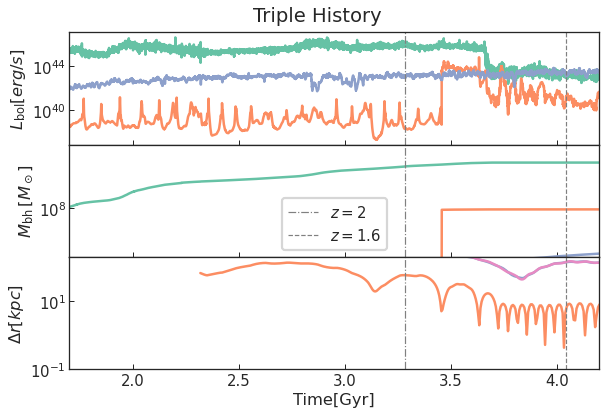

In [25]:
plot_trip_history(bh1,bh2,bh3,zmerge=redshift)

In [26]:
del bh1
del bh2
del bh3

## Distributions

In [27]:
bhmasses = []
drs = []

for i in range(len(triples_values)):
    bhmasses.append(triples_values['BHMass1'][i]*1e10/hh[0])
    bhmasses.append(triples_values['BHMass2'][i]*1e10/hh[0])
    bhmasses.append(triples_values['BHMass3'][i]*1e10/hh[0])
    drs.append(triples_values['drmin'][i])
    drs.append(triples_values['drmed'][i])
    drs.append(triples_values['drmax'][i])

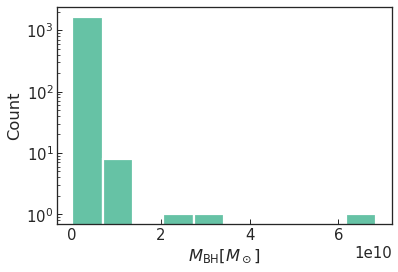

In [28]:
plt.hist(bhmasses, bins=10,log=True)
plt.xlabel(r'$M_{\rm BH} [M_\odot]$')
plt.ylabel('Count')
plt.show()

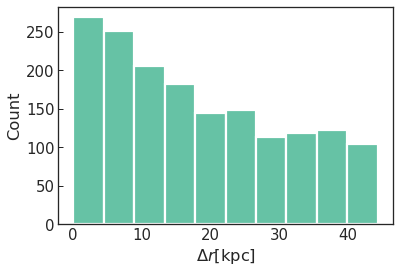

In [29]:
plt.hist(drs, bins=10)
plt.xlabel(r'$\Delta r [\rm kpc]$')
plt.ylabel('Count')
plt.show()